In [1]:
from datasets import load_dataset
from datasets import Image as ImageFeature
import matplotlib.pyplot as plt
import numpy as np
import transformers
from util import transform, load_model


/content/train.py:6: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [2]:
dataset = load_dataset('competitions/aiornot').cast_column('image', ImageFeature())

  0%|          | 0/2 [00:00<?, ?it/s]

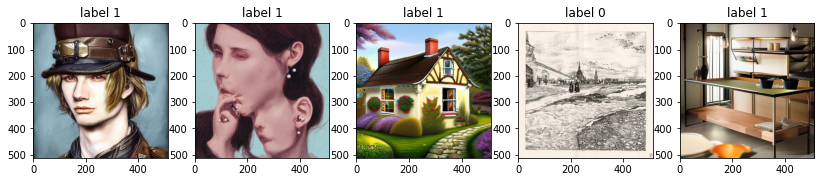

In [3]:
n_imgs = 5
train_size = len(dataset['train'])
fig, axes = plt.subplots(ncols=n_imgs, nrows=1, figsize=(14,14))
for i in range(n_imgs):
  j = np.random.randint(0, train_size-1)
  axes[i].imshow(dataset['train'][j]['image'])
  axes[i].set_title(f"label {dataset['train'][j]['label']}")

### Train

In [4]:
e_ds = dataset['train'].train_test_split(test_size=0.05)
p_ds = e_ds.with_transform(transform)
trainer = load_model(p_ds)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using cuda_amp half precision backend


In [5]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 16756
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1048
  Number of trainable parameters = 85800194


Step,Training Loss,Validation Loss,Accuracy
200,0.330000,0.270184,0.893663
400,0.227800,0.239791,0.895811
600,0.172200,0.103570,0.959721
800,0.110700,0.089307,0.966165
1000,0.098000,0.072313,0.969388


***** Running Evaluation *****
  Num examples = 1862
  Batch size = 8
Saving model checkpoint to ./vit-base-ai-or-not/checkpoint-200
Configuration saved in ./vit-base-ai-or-not/checkpoint-200/config.json
Model weights saved in ./vit-base-ai-or-not/checkpoint-200/pytorch_model.bin
Image processor saved in ./vit-base-ai-or-not/checkpoint-200/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 1862
  Batch size = 8
Saving model checkpoint to ./vit-base-ai-or-not/checkpoint-400
Configuration saved in ./vit-base-ai-or-not/checkpoint-400/config.json
Model weights saved in ./vit-base-ai-or-not/checkpoint-400/pytorch_model.bin
Image processor saved in ./vit-base-ai-or-not/checkpoint-400/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 1862
  Batch size = 8
Saving model checkpoint to ./vit-base-ai-or-not/checkpoint-600
Configuration saved in ./vit-base-ai-or-not/checkpoint-600/config.json
Model weights saved in ./vit-base-ai-or-not/checkpoint-600/pyt

***** train metrics *****
  epoch                    =          1.0
  total_flos               = 1209281178GF
  train_loss               =       0.1833
  train_runtime            =   0:09:46.86
  train_samples_per_second =       28.552
  train_steps_per_second   =        1.786


In [9]:
!zip -r vit-base-ai-or-not.zip vit-base-ai-or-not

  adding: vit-base-ai-or-not/ (stored 0%)
  adding: vit-base-ai-or-not/checkpoint-800/ (stored 0%)
  adding: vit-base-ai-or-not/checkpoint-800/trainer_state.json (deflated 69%)
  adding: vit-base-ai-or-not/checkpoint-800/rng_state.pth (deflated 28%)
  adding: vit-base-ai-or-not/checkpoint-800/scheduler.pt (deflated 49%)
  adding: vit-base-ai-or-not/checkpoint-800/training_args.bin (deflated 49%)
  adding: vit-base-ai-or-not/checkpoint-800/pytorch_model.bin (deflated 7%)
  adding: vit-base-ai-or-not/checkpoint-800/scaler.pt (deflated 55%)
  adding: vit-base-ai-or-not/checkpoint-800/config.json (deflated 46%)
  adding: vit-base-ai-or-not/checkpoint-800/preprocessor_config.json (deflated 45%)
  adding: vit-base-ai-or-not/checkpoint-800/optimizer.pt (deflated 8%)
  adding: vit-base-ai-or-not/trainer_state.json (deflated 72%)
  adding: vit-base-ai-or-not/train_results.json (deflated 37%)
  adding: vit-base-ai-or-not/runs/ (stored 0%)
  adding: vit-base-ai-or-not/runs/Feb04_16-17-16_75942feb

In [12]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [13]:
!cp vit-base-ai-or-not.zip 'gdrive/MyDrive/Colab Notebooks/'

### Evaluation (log-loss score)

In [19]:
preds = trainer.predict(p_ds['test'])

***** Running Prediction *****
  Num examples = 1862
  Batch size = 8


In [31]:
from torch import nn
import torch

preds_out = torch.tensor(preds.predictions).float()
probabilities = nn.functional.softmax(preds_out, dim=1)


tensor([[9.9973e-01, 2.7265e-04],
        [9.9939e-01, 6.0945e-04],
        [9.9989e-01, 1.0721e-04],
        ...,
        [9.9994e-01, 6.0850e-05],
        [2.6626e-03, 9.9734e-01],
        [1.0994e-01, 8.9006e-01]])

In [44]:
from sklearn.metrics import log_loss

y_true =  np.array(e_ds['test']['label'])
log_loss(y_true, probabilities[:,1])

0.07231124504888074

In [52]:
# true test set
p_test = dataset['test'].with_transform(transform)

* neural network that outputs class probabilities (binary), as eval metric is logloss

### plan:
* fine tune large pre-trained model, evaluate log loss on multiple different models
* try zero-shot classification model